## Day 12: Hill Climbing Algorithm ---

You try contacting the Elves using your handheld device, but the river you're following must be too low to get a decent signal.

You ask the device for a heightmap of the surrounding area (your puzzle input). The heightmap shows the local area from above broken into a grid; the elevation of each square of the grid is given by a single lowercase letter, where `a` is the lowest elevation, `b` is the next-lowest, and so on up to the highest elevation, `z`.

Also included on the heightmap are marks for your current position (`S`) and the location that should get the best signal (`E`). Your current position (`S`) has elevation `a`, and the location that should get the best signal (`E`) has elevation `z`.

You'd like to reach `E`, but to save energy, you should do it in **as few steps as possible**. During each step, you can move exactly one square up, down, left, or right. To avoid needing to get out your climbing gear, the elevation of the destination square can be **at most one higher than the elevation of your current square**; that is, if your current elevation is `m`, you could step to elevation `n`, but not to elevation `o`. (This also means that the elevation of the destination square can be much lower than the elevation of your current square.)

For example:

```
Sabqponm
abcryxxl
accszExk
acctuvwj
abdefghi
```

Here, you start in the top-left corner; your goal is near the middle. You could start by moving down or right, but eventually you'll need to head toward the e at the bottom. From there, you can spiral around to the goal:

```
v..v<<<<
>v.vv<<^
.>vv>E^^
..v>>>^^
..>>>>>^
```

In the above diagram, the symbols indicate whether the path exits each square moving up (`^`), down (`v`), left (`<`), or right (`>`). The location that should get the best signal is still `E`, and `.` marks unvisited squares.

> Aquí hay una explicación cojonuda del **algoritmo A*** (Una mejora sobre el Djikstra) que
> está, como decía Joselín de Ubrique, en cuatro palabras:  **es-pec-ta-cu-lar**:
>
> - [Introduction to the A* Algorithm - from Red Blob Games](https://www.redblobgames.com/pathfinding/a-star/introduction.html)

In [1]:
import pytest
from icecream import ic

In [2]:
def load_input(filename):
    node_map = {}
    start_at = None
    end_at = None
    with open(filename, 'r') as f_input:
        for y, line in enumerate(f_input):
            line = line.strip()
            for x, char in enumerate(line):
                point = (x, y)
                if char == 'S':
                    start_at = point
                    node_map[point] = 'a'
                elif char == 'E':
                    end_at = point
                    node_map[point] = 'z'
                else:
                    node_map[point] = char
    return x + 1, y + 1, node_map, start_at, end_at

In [4]:
width, height, node_map, start_at, end_at = load_input('sample.txt')
assert start_at == (0, 0)
assert end_at == (5, 2)
assert node_map[0, 0] == 'a'
assert node_map[5, 2] == 'z'
assert node_map[2, 2] == 'c'
assert node_map[7, 4] == 'i'
assert ic(width) == 8
assert ic(height) == 5

ic| width: 8
ic| height: 5


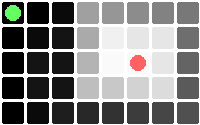

In [6]:
from show import create_map_image

width, height, node_map, start_at, end_at = load_input('sample.txt')
img = create_map_image(width, height, node_map, start_at, end_at)
img.save('sample.png')
img

> Vamos a necesitar una función que nos devuelve los vecimos de una celda

In [7]:
def all_neighbours(width, height, nodes_map, x, y):
    if 0 < x <= width:
        yield x-1, y, nodes_map[x - 1, y]
    if 0 <= y < (height - 1):
        yield x, y + 1, nodes_map[x, y + 1]
    if 0 <= x < (width - 1):
        yield x+1, y, nodes_map[x + 1, y]
    if 0 < y <= height:
        yield x, y - 1, nodes_map[x, y - 1]
    
width, height, node_map, *_ = load_input('sample.txt')

assert list(all_neighbours(width, height, node_map, -2, -2)) == []
assert list(all_neighbours(width, height, node_map, -1, -1)) == []
assert list(all_neighbours(width, height, node_map, 1, 1)) == [
    (0, 1, 'a'),
    (1, 2, 'c'),
    (2, 1, 'c'),
    (1, 0, 'a'),
]

In [8]:
assert list(all_neighbours(width, height, node_map, 2, 3)) == [
    (1, 3, 'c'),
    (2, 4, 'd'),
    (3, 3, 't'),
    (2, 2, 'c'),
]

# Top left corner
assert list(all_neighbours(width, height, node_map, 0, 0)) == [(0, 1, 'a'), (1, 0, 'a')]
# Top right corner
assert list(all_neighbours(width, height, node_map, 7, 0)) == [(6, 0, 'n'), (7, 1, 'l')]
# Left bottom corner
assert list(all_neighbours(width, height, node_map, 0, 4)) == [(1, 4, 'b'), (0, 3, 'a')]
# Right bottom corner
assert list(all_neighbours(width, height, node_map, 7, 4)) == [(6, 4, 'h'), (7, 3, 'j')]

> Y otra que nos devuelve los vecimos a los que se puede acceder

In [9]:
def neighbours(width, height, nodes_map, x, y):
    char = nodes_map[(x, y)]
    tope = ord(char) + 1
    yield from (
        (_x, _y)
        for (_x, _y, _char) in all_neighbours(width, height, nodes_map, x, y)
        if ord(_char) <= tope
    )

assert list(neighbours(width, height, node_map, 0, 0)) == [(0, 1), (1, 0)]
assert list(neighbours(width, height, node_map, 2, 3)) == [
    (1, 3),
    (2, 4),
    (2, 2),
]

> Necesitaremos una cola por prioridades

In [10]:
# Priory class
from typing import Any
import heapq

class PriorityQueue:
    
    def __init__(self):
        self.kernel = []
        heapq.heapify(self.kernel)
        self.size = 0
    
    def is_empty(self) -> bool:
        return self.size == 0
    
    def __len__(self) -> int:
        return self.size
    
    def push(self, prioridad: int, item: Any):
        heapq.heappush(self.kernel, (prioridad, item))
        self.size += 1
    
    def pop(self) -> Any:
        self.size -= 1
        _priority, result = heapq.heappop(self.kernel)
        return result
    
pq = PriorityQueue()
assert len(pq) == 0
assert pq.is_empty()
pq.push(1, 'mundo')
assert len(pq) == 1
pq.push(0, 'hola')
assert len(pq) == 2
s = f"{pq.pop()} {pq.pop()}"
assert s == 'hola mundo'
assert len(pq) == 0
assert pq.is_empty()

> Necesitaremos una [heurística admisible](https://es.wikipedia.org/wiki/Heur%C3%ADstica_admisible)

In [11]:
def heuristic(a, b):  # Manhattan distance on a square grid
    x0, y0 = a
    x1, y1 = b
    return abs(x1 - x0) + abs(y1 - y0)

assert heuristic((0, 0), (3, 6)) == 9
assert heuristic((3, 7), (-1, 9)) == 6

In [12]:
def a_asterisk(width, height, node_map, start_at, end_at):
    frontier = PriorityQueue()
    frontier.push(0, start_at)
    came_from = {start_at: None}
    cost_so_far = {start_at: 0}
    while not frontier.is_empty():
        current_node = (x, y) = frontier.pop()
        if current_node == end_at:
            break
        for next_x, next_y in neighbours(width, height, node_map, x, y):
            next_node = (next_x, next_y)
            new_cost = cost_so_far[current_node] + 1
            if next_node not in cost_so_far or new_cost < cost_so_far[next_node]:
                cost_so_far[next_node] = new_cost
                priority = new_cost + heuristic(end_at, next_node)
                frontier.push(priority, next_node)
                came_from[next_node] = current_node
    return came_from    


def get_shortest_path(start_at, end_at, came_from):
    current_node = end_at
    path = []
    while current_node != start_at:
        path.append(current_node)
        current_node = came_from[current_node]
    path.reverse()
    return path

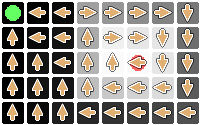

In [14]:
from show import show_came_from   
width, height, node_map, start_at, end_at = load_input('sample.txt')
came_from = a_asterisk(width, height, node_map, start_at, end_at)
assert start_at in came_from
assert end_at in came_from
im = show_came_from(width, height, node_map, start_at, end_at, came_from)
im.save('map_path.png')
im

In [15]:
def solution_one(filename):
    width, height, node_map, start_at, end_at = load_input(filename)
    came_from = a_asterisk(width, height, node_map, start_at, end_at)
    return len(get_shortest_path(start_at, end_at, came_from))

This path reaches the goal in **31** steps, the fewest possible.

What is the fewest steps required to move from your current position to the location that should get the best signal?

In [16]:
assert solution_one('sample.txt') == 31

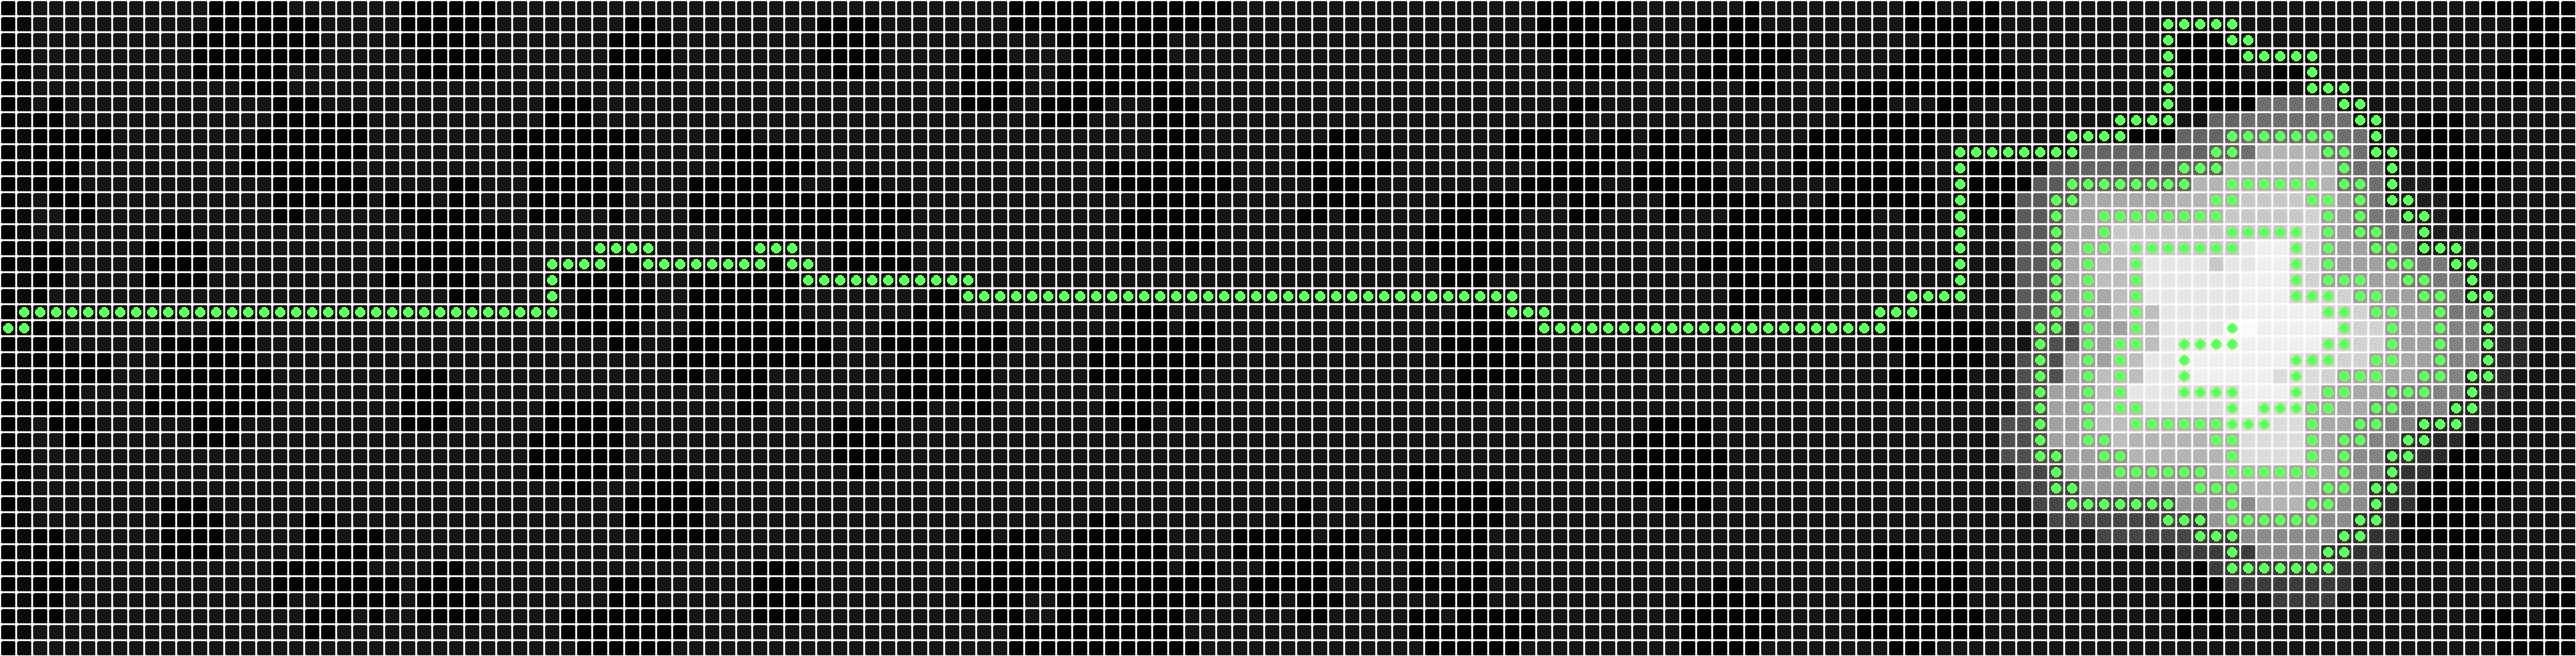

In [17]:
from PIL import ImageDraw
from show import dot

def show_path(width, height, node_map, path):
    im = create_map_image(width, height, node_map, start_at, end_at)
    draw = ImageDraw.Draw(im)
    for (x, y) in path:
        dot(draw, (x, y))    
    return im

width, height, node_map, start_at, end_at = load_input('input.txt')
came_from = a_asterisk(width, height, node_map, start_at, end_at)
show_path(width, height, node_map, get_shortest_path(start_at, end_at, came_from))

In [18]:
sol = solution_one('input.txt')
print(f"Solution part one: {sol}")

Solution part one: 481


## Part Two

As you walk up the hill, you suspect that the Elves will want to turn this into a hiking trail. The beginning isn't very scenic, though; perhaps you can find a better starting point.

To maximize exercise while hiking, the trail should start as low as possible: elevation a. The goal is still the square marked E. However, the trail should still be direct, taking the fewest steps to reach its goal. So, you'll need to find the shortest path from any square at elevation a to the square marked E.

Again consider the example from above:

```
Sabqponm
abcryxxl
accszExk
acctuvwj
abdefghi
```

Now, there are six choices for starting position (five marked a, plus the square marked S that counts as being at elevation a). If you start at the bottom-left square, you can reach the goal most quickly:

```
...v<<<<
...vv<<^
...v>E^^
.>v>>>^^
>^>>>>>^
```

This path reaches the goal in only 29 steps, the fewest possible.

What is the fewest steps required to move starting from any square with elevation a to the location that should get the best signal?

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1779/1779 [02:11<00:00, 13.58it/s]


480


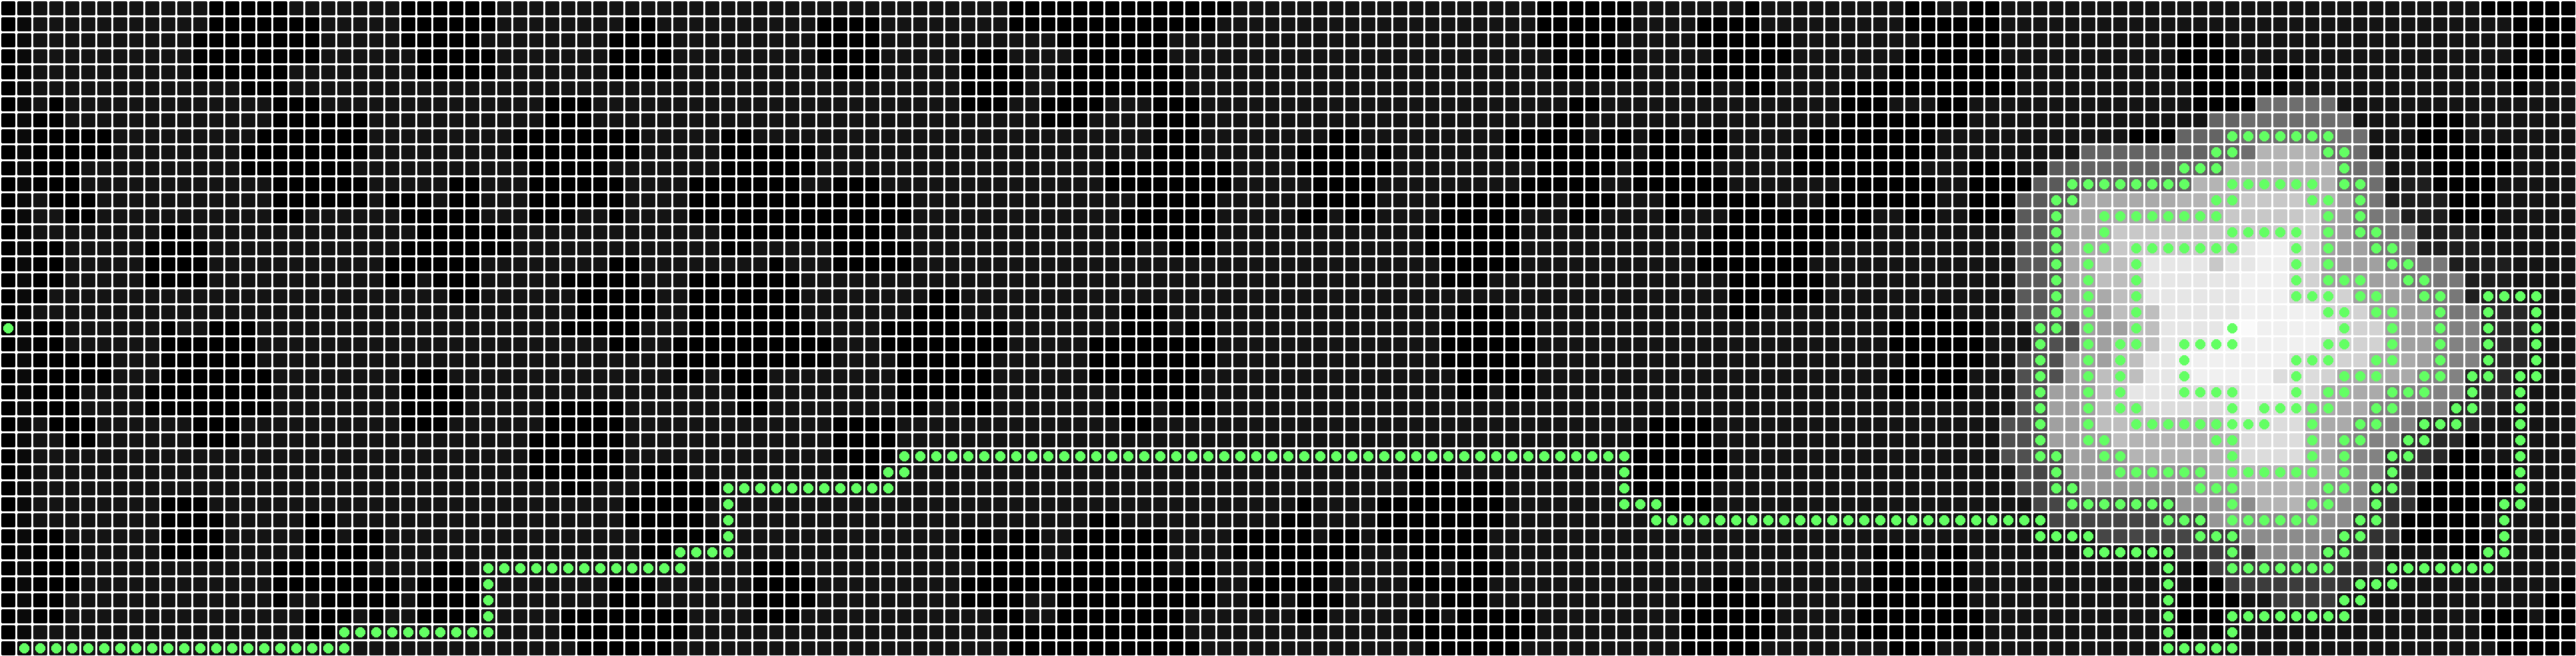

In [20]:
from tqdm import tqdm

width, height, node_map, start_at, end_at = load_input('input.txt')
candidates = [(x, y) for (x, y) in node_map if node_map[x, y] == 'a']

min_length = 99999999999

for candidate in tqdm(candidates):
    came_from = a_asterisk(width, height, node_map, candidate, end_at)
    try:
        path = get_shortest_path(candidate, end_at, came_from)
    except KeyError:
        pass
    im = show_path(width, height, node_map, path)
    length = len(path)
    if length < min_length:
        min_length = length
print(min_length)
sol = min_length
im

In [21]:
print(f"Solution part two: {sol}")

Solution part two: 480
